In [37]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import FunctionTransformer, StandardScaler, Imputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.feature_extraction import FeatureHasher
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.pyplot as plt
import math
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBClassifier, XGBRegressor

# Load some data
full_train = pd.read_csv('train.csv', squeeze=True)
test = pd.read_csv('test.csv', squeeze=True)
sample_submission = pd.read_csv('sample_submission.csv', squeeze=True)

In [38]:
# Exploratory Data Analysis
print full_train.shape
print test.shape

(1460, 81)
(1459, 80)


In [39]:
naCounts = full_train.isna().sum()
naCounts[naCounts>0].sort_values(ascending=False)
naCols = [
"PoolQC",
"MiscFeature",
"Alley",
"Fence",
"FireplaceQu",
"LotFrontage",
"GarageYrBlt",
"GarageType",
"GarageFinish",
"GarageQual",
"GarageCond",
]

In [52]:
full_s_fields = [
    'MSZoning',
    'Street',
    'Alley',
    'LotShape',
    'LandContour',
    'Utilities',
    'LotConfig',
    'LandSlope',
    'Neighborhood',
    'Condition1',
    'Condition2',
    'BldgType',
    'HouseStyle',
    'OverallQual',
    'RoofStyle',
    'RoofMatl',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'ExterQual',
    'ExterCond',
    'Foundation',
    'BsmtQual',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'Heating',
    'HeatingQC',
    'CentralAir',
    'Electrical',
    'KitchenQual',
    'Functional',
    'FireplaceQu',
    'GarageType',
    'GarageFinish',
    'GarageQual',
    'GarageCond',
    'PavedDrive',
    'PoolQC',
    'Fence',
    'MiscFeature',
    'SaleType',
    'MSSubClass',
    'SaleCondition'
]
full_n_fields = [
    'LotFrontage',
    'LotArea',
    'YearBuilt',
    'YearRemodAdd',
    'MasVnrArea',
    'BsmtFinSF1',
    'BsmtFinSF2',
    'BsmtUnfSF',
    'TotalBsmtSF',
    '1stFlrSF',
    '2ndFlrSF',
    'LowQualFinSF',
    'GrLivArea',
    'BsmtFullBath',
    'BsmtHalfBath',
    'FullBath',
    'HalfBath',
    'BedroomAbvGr',
    'KitchenAbvGr',
    'TotRmsAbvGrd',
    'Fireplaces',
    'GarageYrBlt',
    'GarageCars',
    'GarageArea',
    'WoodDeckSF',
    'OpenPorchSF',
    'EnclosedPorch',
    '3SsnPorch',
    'ScreenPorch',
    'PoolArea',
    'YrSold',
    'MoSold',
    'MiscVal',
    'SalePrice',
]

s_fields = [ c for c in full_s_fields if not c in naCols]
n_fields = [c for c in full_n_fields if not c in naCols]
new_cols = n_fields + s_fields

In [53]:
na_full_train = full_train[new_cols]

In [54]:
na_full_train[s_fields].isna().sum()

MSZoning          0
Street            0
LotShape          0
LandContour       0
Utilities         0
LotConfig         0
LandSlope         0
Neighborhood      0
Condition1        0
Condition2        0
BldgType          0
HouseStyle        0
OverallQual       0
RoofStyle         0
RoofMatl          0
Exterior1st       0
Exterior2nd       0
MasVnrType        8
ExterQual         0
ExterCond         0
Foundation        0
BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinType2     38
Heating           0
HeatingQC         0
CentralAir        0
Electrical        1
KitchenQual       0
Functional        0
PavedDrive        0
SaleType          0
MSSubClass        0
SaleCondition     0
dtype: int64

In [55]:
def make_map(X):
    mapCounts = {}
    new_X = X[:]
    for c_idx, col_val in enumerate(X.columns):
        if col_val in s_fields:
            mapCounts[col_val] = []
            for r_idx, row_val in enumerate(X[col_val]):
                if row_val is not np.nan:
                    if row_val not in mapCounts[col_val]:
                        mapCounts[col_val].append(row_val)
                    new_X.iloc[r_idx, c_idx] = mapCounts[col_val].index(row_val) + 1
    return new_X
mapped_train = make_map(na_full_train)
mapped_train.shape

(1460, 68)

LotFrontage    259
GarageYrBlt     81
MasVnrArea       8
dtype: int64

In [56]:
new_train = mapped_train.copy()
to_drop = []
for r_idx, row in full_train.iterrows():
    for c_idx, val in enumerate(row):
        c_name = full_train.columns[c_idx]
        if c_name in n_fields:
            c_mean = full_train[c_name].mean()
            val_diff = np.abs(val - c_mean)
            c_std = full_train[c_name].std()
            if val_diff >= 3 * c_std:
                to_drop.append(r_idx)
drop_train = new_train.drop(new_train.index[to_drop])
drop_train.shape

(1045, 68)

In [66]:
imp_train = drop_train.copy()
imp = Imputer(strategy='mean')
imp_transform = imp.fit_transform(imp_train)
imp_transform
imp_train[new_cols] = imp_transform

0

In [58]:

def root_mean_square_error(pred, actual):
    log_actual = np.log(actual)
    log_pred = np.log(pred)
    return np.sqrt(mean_squared_error(log_actual, log_pred))

In [72]:
# Set target and predictors
target = 'SalePrice'
predictors = [c for c in imp_train.columns if not c == target]

# Train/test split
X = imp_train[predictors]
y = imp_train[[target]]
X_train, X_dev, y_train, y_dev = train_test_split(X, y, random_state=1)
X_test = test[predictors]

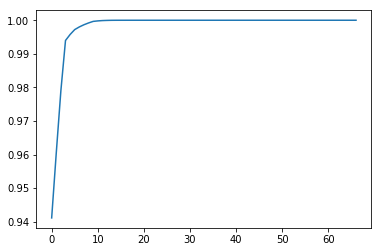

In [78]:
pca = PCA(n_components=67)
train_transform = pca.fit_transform(X_train)
dev_transform = pca.transform(X_dev)
plt.plot(np.cumsum(pca.explained_variance_ratio_))


In [81]:
def make_csv(name, pred):
    new_df = test.copy()
    new_df['SalePrice'] = pred
    new_df[['Id', 'SalePrice']].to_csv(name, index=False)

In [82]:
# ridge with PCA
rid = Ridge()
search_params = {
    'preprocess__reduction__n_components': [10],
    'predict__alpha': [10.0],
    'predict__fit_intercept': [False],
    'predict__solver': ["cholesky"],
    'predict__random_state': [1],
}
model_pipe = Pipeline(steps=[
    ('preprocess', fr),
    ('predict', rid)
])

round_num = 2
grid_search = GridSearchCV(model_pipe, search_params, cv=5)
grid_search.fit(X_train, np.log(y_train).round(round_num))
print grid_search.best_params_
print grid_search.score(X_dev, np.log(y_dev).round(round_num))
print root_mean_square_error(grid_search.predict(X_dev), np.log(y_dev).round(round_num))
pred = grid_search.predict(X_test)

{'predict__random_state': 1, 'predict__alpha': 10.0, 'predict__fit_intercept': False, 'preprocess__reduction__n_components': 10, 'predict__solver': 'cholesky'}
-899.9692192926192


/Users/brandoncummings/anaconda2/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').